In [9]:
import pandas as pd
import matplotlib.pyplot as plt
dataset = pandas.read_csv('bitcoin_ticker.csv', engine='python', skipfooter=3)
#dataset = dataset[dataset['rpt_key'] == "btc_krw"]['bid']
#dataset.reshape(len(dataset),1)
#plt.plot(dataset)
#plt.show()


           date_id          datetime_id  market  rpt_key       last  \
382562  2017-06-27  2017-06-27 13:36:00  korbit  btc_krw  3164500.0   
382572  2017-06-27  2017-06-27 13:37:00  korbit  btc_krw  3166000.0   
382582  2017-06-27  2017-06-27 13:38:00  korbit  btc_krw  3169000.0   
382592  2017-06-27  2017-06-27 13:39:00  korbit  btc_krw  3158000.0   
382602  2017-06-27  2017-06-27 13:40:00  korbit  btc_krw  3152000.0   
382612  2017-06-27  2017-06-27 13:41:00  korbit  btc_krw  3153000.0   
382622  2017-06-27  2017-06-27 13:42:00  korbit  btc_krw  3157500.0   
382632  2017-06-27  2017-06-27 13:43:00  korbit  btc_krw  3168500.0   
382642  2017-06-27  2017-06-27 13:44:00  korbit  btc_krw  3169000.0   
382652  2017-06-27  2017-06-27 13:45:00  korbit  btc_krw  3170000.0   
382662  2017-06-27  2017-06-27 13:46:00  korbit  btc_krw  3169500.0   
382672  2017-06-27  2017-06-27 13:47:00  korbit  btc_krw  3165500.0   
382682  2017-06-27  2017-06-27 13:48:00  korbit  btc_krw  3169000.0   
382692

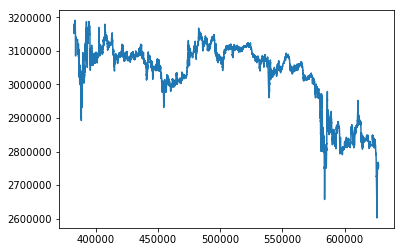

In [10]:
dataset_new = dataset[dataset['date_id']>='2017-06-27']

dataset_new = dataset_new[ dataset_new['rpt_key'] == "btc_krw"]
print dataset_new
plt.plot(dataset_new['bid'])
plt.show()


In [11]:

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [12]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [13]:
# load the dataset
dataset = pd.read_csv('bitcoin_ticker.csv', engine='python')
dataset_new = dataset[dataset['date_id']>='2017-06-27']
dataset_new = dataset_new[ dataset_new['rpt_key'] == "btc_krw"]
dataset = dataset_new['bid'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(len(dataset),1)

In [14]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [45]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(16390, 8073)


In [46]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return numpy.array(dataX), numpy.array(dataY)

In [47]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [48]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [49]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=50, verbose=2)

Epoch 1/10
4s - loss: 0.0666
Epoch 2/10
3s - loss: 0.0012
Epoch 3/10
3s - loss: 9.8678e-04
Epoch 4/10
3s - loss: 7.4264e-04
Epoch 5/10
3s - loss: 4.9944e-04
Epoch 6/10
3s - loss: 2.8895e-04
Epoch 7/10
3s - loss: 1.3373e-04
Epoch 8/10
3s - loss: 5.2844e-05
Epoch 9/10
2s - loss: 3.1289e-05
Epoch 10/10
3s - loss: 2.8808e-05


In [50]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[0,:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[0, :]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2269.75 RMSE
Test Score: 873.75 RMSE


(24463, 1)


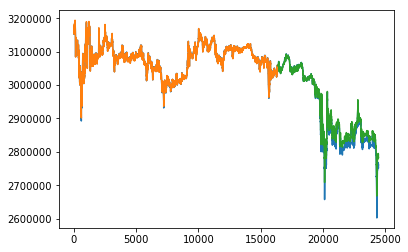

[[ 0.95589495]
 [ 0.95419836]
 [ 0.94826126]
 ..., 
 [ 0.27480936]
 [ 0.26632738]
 [ 0.26717567]]
[[  1.86681341e+12]
 [  1.86619449e+12]
 [  1.86403167e+12]
 ..., 
 [  1.80218495e+12]
 [  1.80276809e+12]
 [  1.80364378e+12]]
[[ 3166769.75]
 [ 3165719.75]
 [ 3162050.75]
 ..., 
 [ 3057137.  ]
 [ 3058126.25]
 [ 3059611.75]]


In [51]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
print trainPredictPlot.shape
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
